In [165]:
import copy
import numpy as np
from scipy.linalg import norm
from scipy import linalg 
import math
from matplotlib import mlab
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.pyplot as plt
import symengine
import sympy as sy
from sympy.functions import sin,cos
from numpy.linalg import inv

Для жестких систем вида $$\frac{du}{dt}= f(u), u(t_0)=u_0$$
т.е. где правая часть не зависит от $t$, применяется невяный метод Розенброка - в нашем случае 4-х стадийный метод порядка точности:
$$u_{n+1}=u_n + \sum_{i=1}^{4}p_ik_i $$
$$D_nk_1=h\cdot f(u_n)$$
$$D_nk_2=k_1 $$
$$D_nk_3=h\cdot f(u_n+b_{31}k_1+b_{32}k_2)+l_{32}k_2 $$
$$D_nk_4=k_3+l_{42}k_2 $$
$$D_n = E - ahJ(u_n) $$

Раскладывая $u(t_{n+1})$ в ряд Тейлора в окрестности точки $t_n$ и подставляя в выражения для $k$, найдем коэффициенты нашего метода. 

In [167]:
a = 0.57281606248213
p1 = 1.27836939012447
p2 = -1.00738680980438
p3 = 0.92655391093950
p4 = -0.33396131834691
b31 = 1.00900469029922
b32 = -1.007386809804381
l32 = -0.49552206416578
l42 = -1.28777648233922


$$\begin{equation*}
 \begin{cases}
   \varepsilon\dot{x_1} = -(y_1-y_2)-x_2+\psi(x_1), 
   \\
   \varepsilon\dot{x_2} = (y_1-y_2)-x_1+\psi(x_2),
   \\
   \varepsilon\dot{y_1} = x_1,
   \\
   \varepsilon\dot{y_2} = x_2.
 \end{cases}
\end{equation*}$$
$$x_1(0)=x_2(0)=0, y_1(0)=2, y_2(0)=0 $$

In [166]:
def f(xy):
    u = np.zeros(4)
    u[0] = -xy[2] + xy[3] -xy[1]
    u[1] = xy[2] - xy[3] - xy[0]
    u[2] = xy[0]
    u[3] = xy[1]
    return u

Неоднородная часть: 
$$\vec{\psi}= 
\begin{pmatrix}
  -\tan(\pi x_1/2)& \\
  -\tan(\pi x_2/2)& \\
  0 \\
  0
\end{pmatrix},$$





При нулевом приближении  $u(t_0)=u^0=(0,0,2,0)$ имеем:
$$
\begin{pmatrix}
  \dot{x_1^0}& \\
  \dot{x_2^0}& \\
  \dot{y_1^0}& \\
  \dot{y_2^0}
\end{pmatrix} =
\begin{pmatrix}
  2+\psi(x_1^0)& \\
  -2+\psi(x_2^0)& \\
  0& \\
  0
\end{pmatrix}$$

$$ J(u^0)=
\begin{pmatrix}
  -\frac{\pi}{2}(\tan^2(\pi\frac{x_1^0}{2})+1)& 0 &0&0\\
  0&-\frac{\pi}{2}(\tan^2(\pi\frac{x_2^0}{2})+1)& 0&0\\
  0&0&0&0 \\
  0&0&0&0
\end{pmatrix}\approx -\frac{\pi}{2}
\begin{pmatrix}
  (\pi\frac{x_1^0}{2})^2+1& 0 &0&0\\
  0&(\pi\frac{x_2^0}{2})^2+1& 0&0\\
  0&0&0&0 \\
  0&0&0&0
\end{pmatrix}
$$

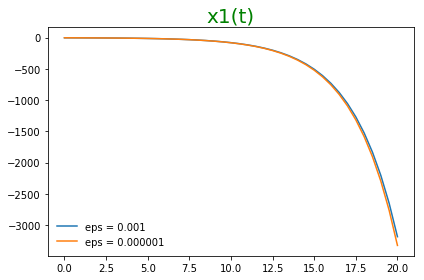

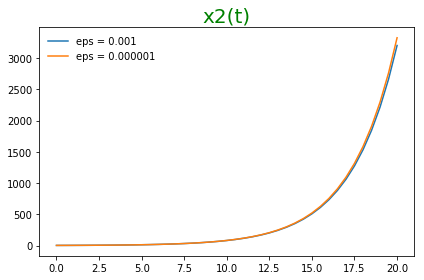

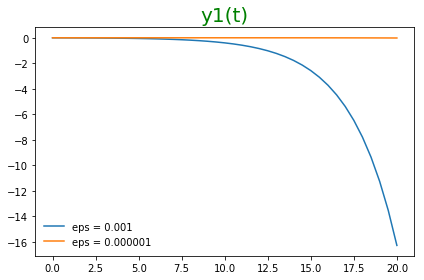

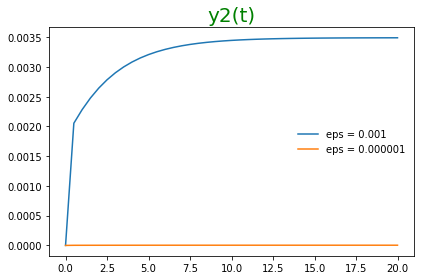

In [201]:
bins = [0.001, 0.000001]
solution_eps = []
for eps in bins:
    t = 0
    h = 0.5
    n = 300
    u0 = np.array([0,0,2,0])
    A = np.array([[0] * (4) for i in range(n+1)]).astype(np.float32)
    p = math.pi
    L = [[0]*4 for i in range(4)]
    L[0][0]=-0.5*p/eps*(1+(0.5*p*u0[1])**2)
    L[1][1]=-0.5*p/eps*(1+(0.5*p*u0[2])**2)
    D = np.eye(4) - h*a*np.array(L)
    D1 = inv(D.astype(np.float32))
    for i in range(4):
        A[0][i] = u0[i]
        i = i + 1

    solution = [[] for i in range(4)] 
    t_data = []
    
    for j in range(n):
        L = [[0]*4 for i in range(4)]
        L[0][0]=-0.5*p/eps*(1+(0.5*p*A[j-1][1])**2)
        L[1][1]=-0.5*p/eps*(1+(0.5*p*A[j-1][2])**2)
        D = np.eye(4) - h*a*np.array(L)
        D1 = inv(D.astype(np.float32))

        k1 = h*np.array([A[j][0],A[j][1],A[j][2],A[j][3]]).dot(D1)
        k2 = k1.dot(D1)
        k3 = (h*f( np.array([A[j][0] + b31*k1[0] + b32*k2[0],
                      A[j][1] + b31*k1[1] + b32*k2[1],
                      A[j][2] + b31*k1[2] + b32*k2[2],
                      A[j][3] + b31*k1[3] + b32*k2[3]])  )+ l32*k2).dot(D1)
        k4 = (k3 + l42*k2).dot(D1)
        K = [[0]*4 for i in range(4)]
        for i in range(3):
            K[0][i] = k1[i]
            K[1][i] = k2[i]
            K[2][i] = k3[i]
            K[3][i] = k4[i]
            i += 1
        for i in range(4):
            for k in range(4):
                A[j + 1][i] += P[k]*K[k][i]
                k += 1
            A[j + 1][i] += A[j][i]
            i += 1
#         print('t = ',t)
#         print(f(([A[j][0],A[j][1],A[j][2],A[j][3]])), 'решение задачи с приближением =', j,'\n')
        for i in range(4):
            solution[i].append(f(([A[j][0],A[j][1],A[j][2],A[j][3] ]))[i])
        t_data.append(t)
        t = t + h 
        if t > 20:
            break
        j = j + 1
    solution_eps.append(solution)
for i in range(4):
    plt.plot(t_data, solution_eps[0][i], label=u'eps = 0.001')
    plt.plot(t_data, solution_eps[1][i], label=u'eps = 0.000001')
    if i < 2:    
        st = 'x' + str(i + 1) + '(t)'
    else:
        st = 'y' + str(i - 1) + '(t)'
    plt.title(st,size=20,color='green')
    plt.legend(loc='best',frameon=False)
    plt.tight_layout()
    plt.show()